In [1]:
import numpy as np

from hfnet.datasets.colmap import Colmap
from hfnet.evaluation.visualize import draw_keypoints
from hfnet.evaluation.loaders import sift_loader, export_loader, fast_loader, harris_loader
from hfnet.evaluation.utils.keypoints import keypoints_warp_3D
from hfnet.evaluation.keypoint_detectors import compute_correctness

from utils import plot_images

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
config = {
    'sequences': ['british_museum', 'london_bridge', 'milan_cathedral','mount_rushmore', 
                  'piazza_san_marco', 'reichstag', 'st_pauls_cathedral',
#                 'florence_cathedral_side', 'lincoln_memorial_statue', 
#                 'united_states_capitol', 'sagrada_familia',
    ],
    'make_pairs': True, 'shuffle': True, 'pair_thresh': 0.4, 'max_num_pairs': 50
}
dataset = Colmap(**config)

[12/05/2018 01:48:20 INFO] Colmap sequence british_museum contains 50 pairs
[12/05/2018 01:48:28 INFO] Colmap sequence london_bridge contains 50 pairs
[12/05/2018 01:48:29 INFO] Colmap sequence milan_cathedral contains 50 pairs
[12/05/2018 01:48:31 INFO] Colmap sequence mount_rushmore contains 50 pairs
[12/05/2018 01:48:34 INFO] Colmap sequence piazza_san_marco contains 50 pairs
[12/05/2018 01:48:35 INFO] Colmap sequence reichstag contains 50 pairs
[12/05/2018 01:48:44 INFO] Colmap sequence st_pauls_cathedral contains 50 pairs


In [3]:
all_configs = {
    'sift': {
        'predictor': sift_loader,
    },
    'harris': {
        'predictor': harris_loader,
        'do_nms': True,
        'nms_thresh': 4,
    },
    'fast': {
        'predictor': fast_loader,
        'do_nms': True,
        'nms_thresh': 4,
    },
    'superpoint': {
        'experiment': 'super_point_pytorch/colmap',
        'predictor': export_loader,
        'do_nms': True,
        'nms_thresh': 4,
        'remove_borders': 4,
        'has_descriptors': False
    },
    'lfnet': {
        'experiment': 'lfnet/colmap_all_kpts-1000',
        'predictor': export_loader,

    },
    'hfnet': {
        'experiment': 'hfnet-shared_weights-unc_aug-photo_glm-bdd_lrsteps/colmap',
        'predictor': export_loader,
        'do_nms': True,
        'nms_thresh': 4,
        'remove_borders': 4,
    }
}
eval_config = {'num_features': 1000}
configs = {c: {**all_configs[c], **eval_config} for c in ['sift', 'superpoint', 'hfnet']}

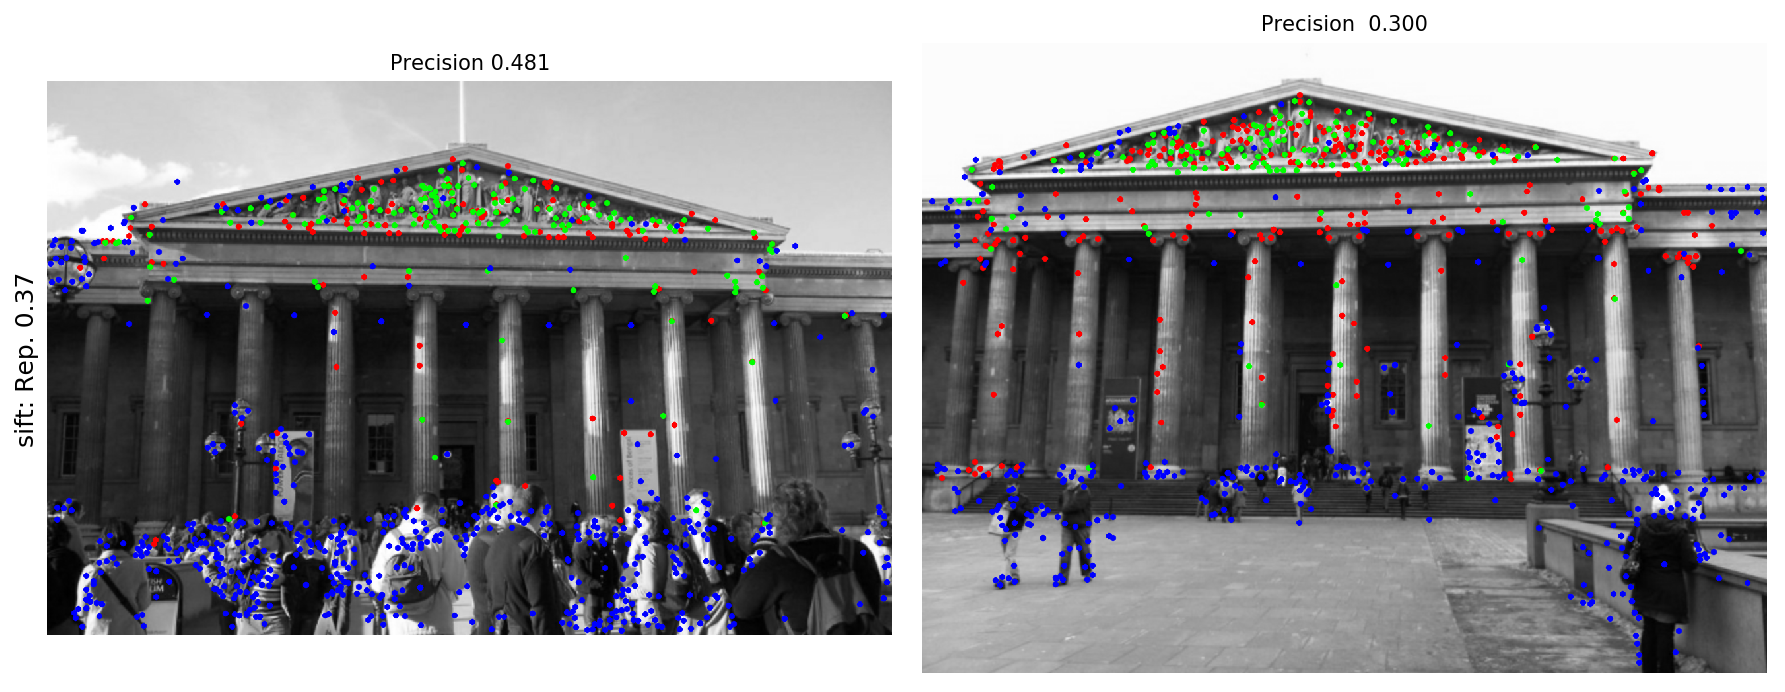

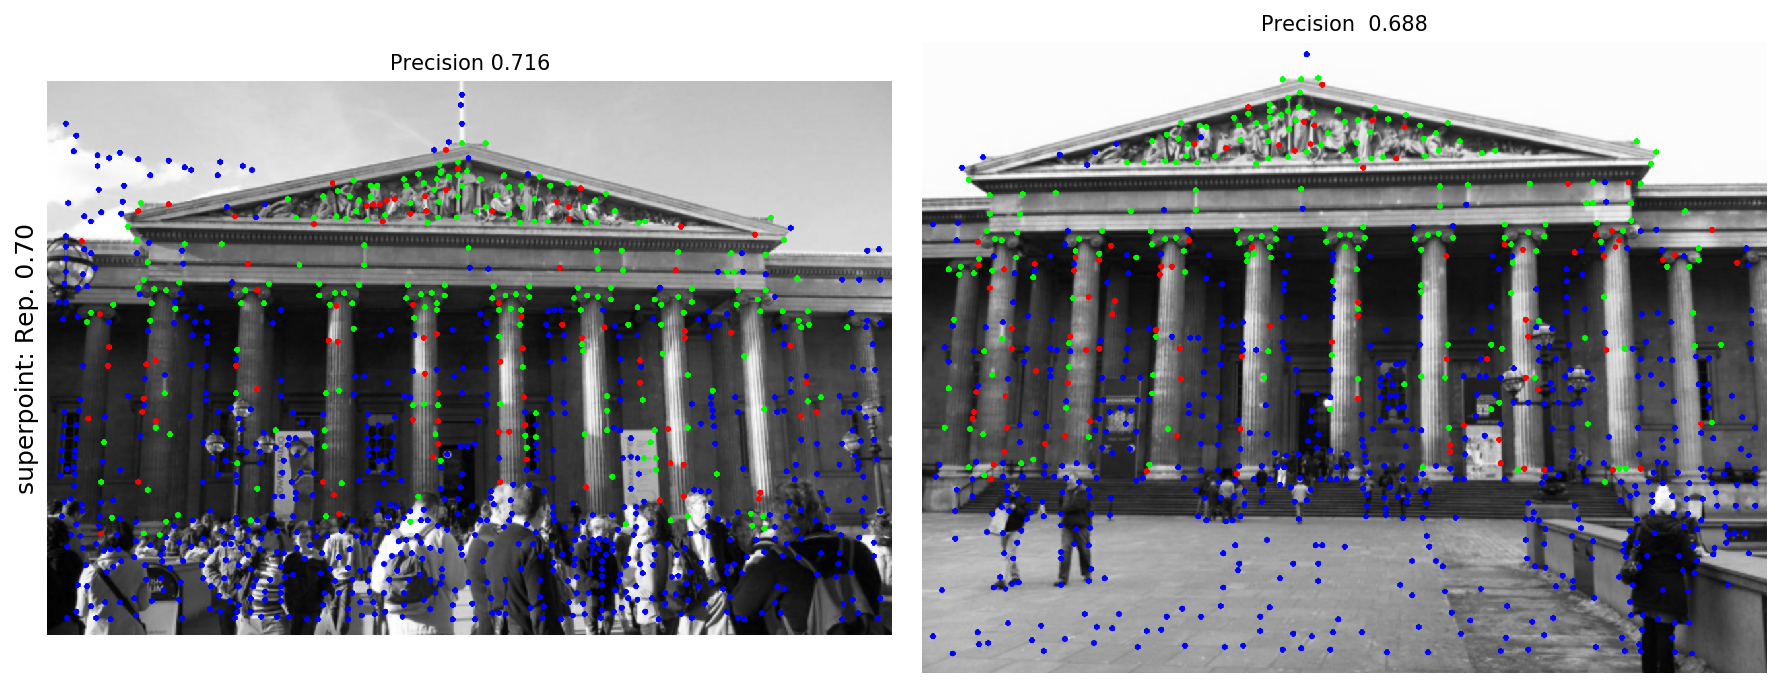

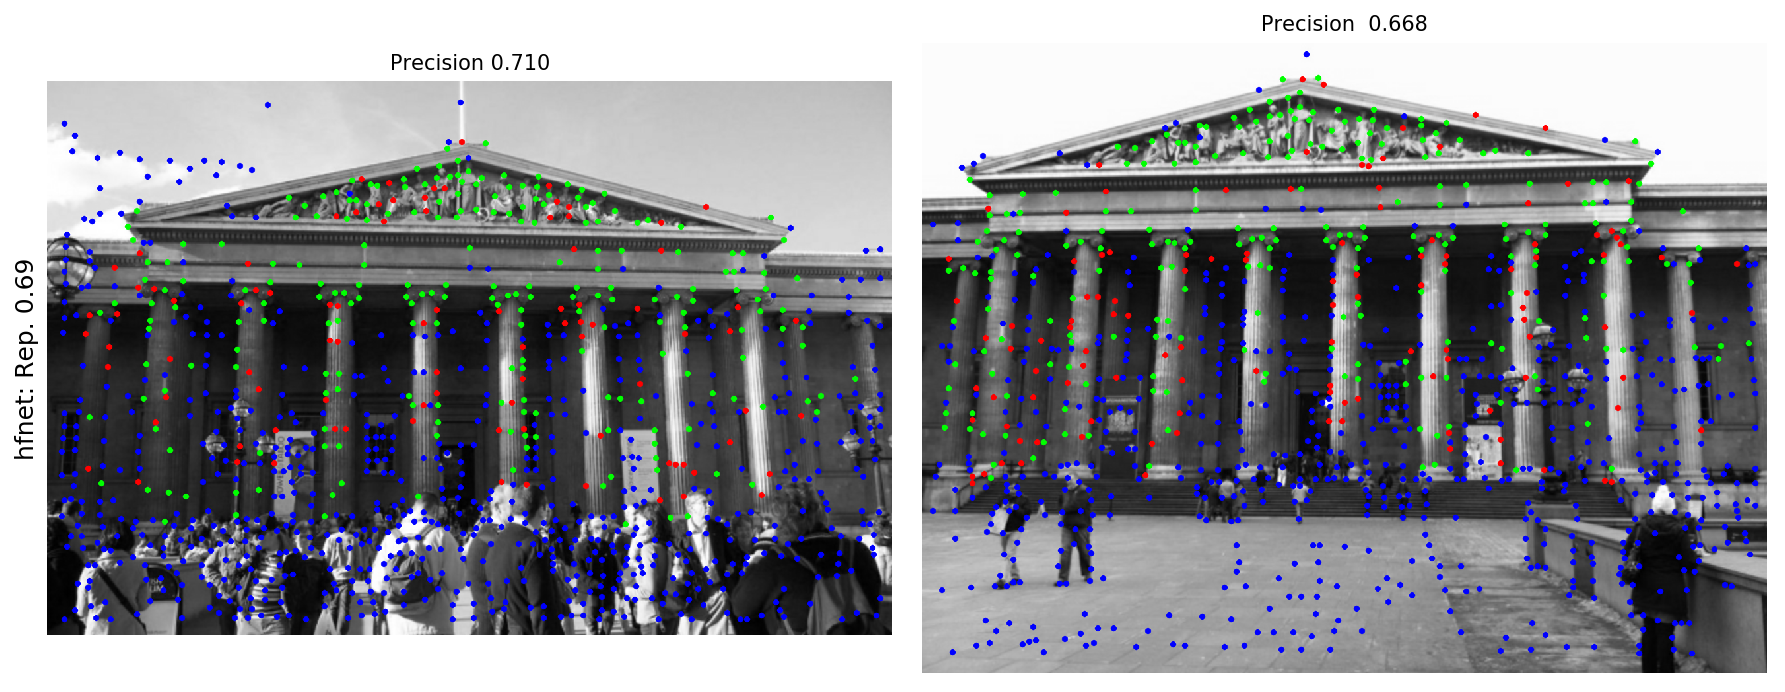

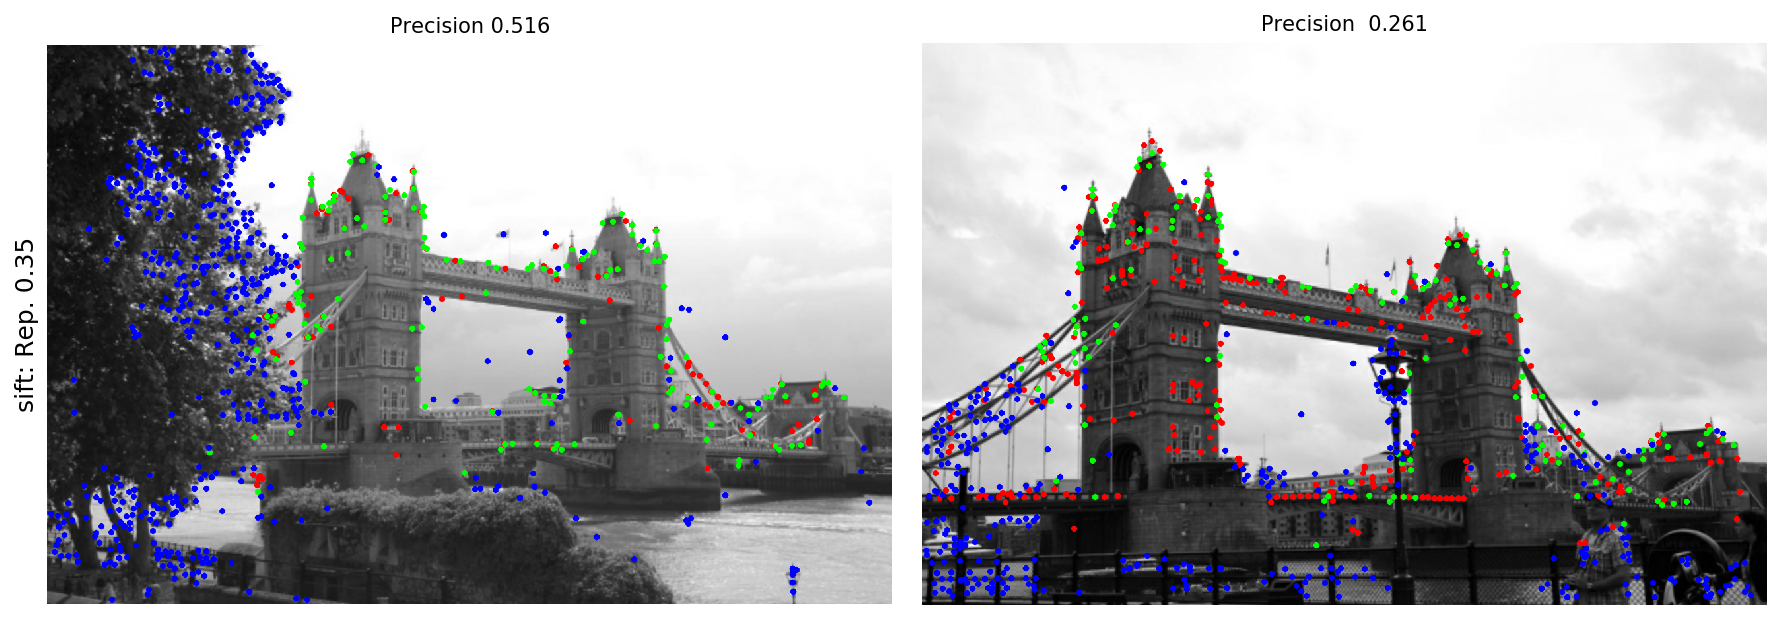

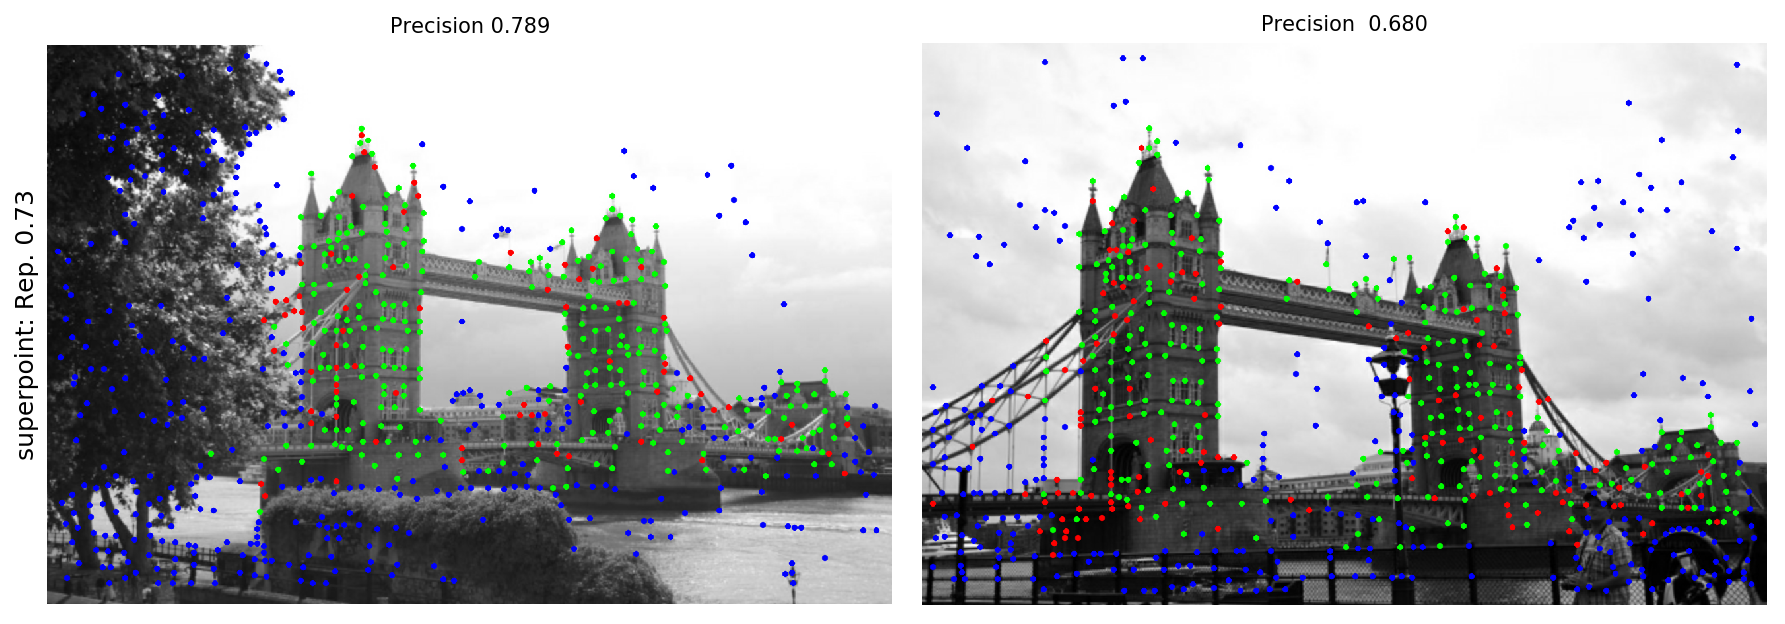

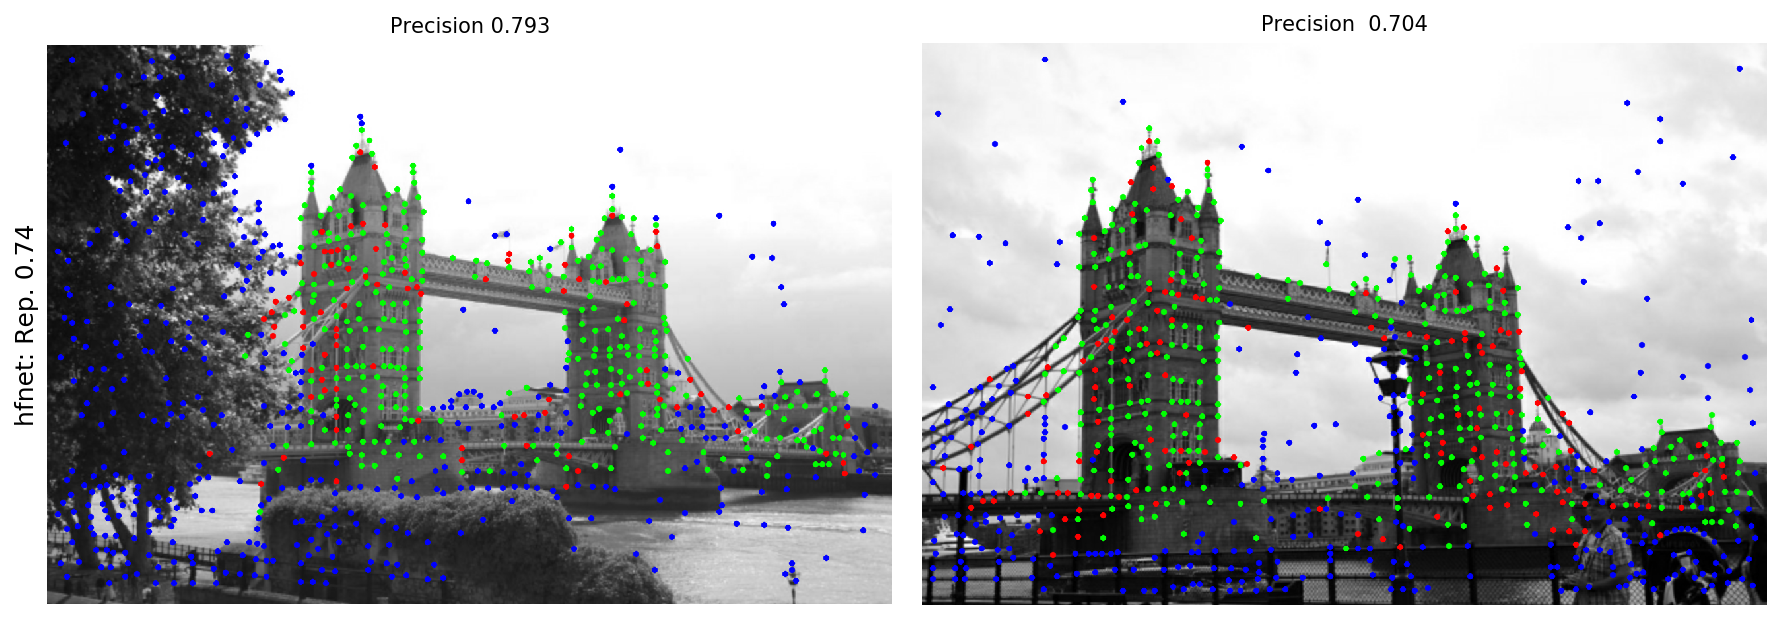

In [5]:
data_iter = dataset.get_test_set()
for _, data in zip(range(2), data_iter):
    for method, config in configs.items():
        pred1 = config['predictor'](data['image'], data['name'], **config)
        pred2 = config['predictor'](data['image2'], data['name2'], **config)
        
        kpts1_w, vis1, _ = keypoints_warp_3D(
            pred1['keypoints'], data['depth'], data['K'], data['K2'],
            np.linalg.inv(data['1_T_2']), data['image2'].shape[1::-1],
            depth2=data['depth2'], consistency_check=True)
        kpts2_w, vis2, _ = keypoints_warp_3D(
            pred2['keypoints'], data['depth2'], data['K2'],
            data['K'], data['1_T_2'], data['image'].shape[1::-1],
            depth2=data['depth'], consistency_check=True)
        correct1, correct2, dist1, dist2 = compute_correctness(
            pred1['keypoints'], pred2['keypoints'], kpts1_w, kpts2_w, 5, mutual=True)
        rep = (correct1[vis1].sum() + correct2[vis2].sum()) / (vis1.sum() + vis2.sum())
        
        im1 = data['image'].astype(np.uint8).copy()
        im1 = draw_keypoints(im1, pred1['keypoints'][vis1&(~correct1)], s=2, radius=4, color=(0,0,255))
        im1 = draw_keypoints(im1, pred1['keypoints'][vis1&correct1]*2, s=1, radius=4)
        im1 = draw_keypoints(im1, pred1['keypoints'][~vis1]*2, s=1, radius=4, color=(255,0,0))
        
        im2 = data['image2'].astype(np.uint8).copy()
        im2 = draw_keypoints(im2, pred2['keypoints'][vis2&(~correct2)], s=2, radius=4, color=(0,0,255))        
        im2 = draw_keypoints(im2, pred2['keypoints'][vis2&correct2]*2, s=1, radius=4)
        im2 = draw_keypoints(im2, pred2['keypoints'][~vis2]*2, s=1, radius=4, color=(255,0,0))
        
        plot_images(
            [im1, im2], ylabel=f'{method}: Rep. {rep:.2f}', labelfont=12, dpi=150,
            titles=[f'Precision {correct1[vis1].mean():.3f}', f'Precision  {correct2[vis2].mean():.3f}'],
        )
                    